In [78]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import *

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

##알고리즘 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

In [79]:
import matplotlib # 글자 깨짐 방지 폰트설정
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

## 데이터 불러오기

In [80]:
df = pd.read_csv("d:/공모전/IPO/IPO/CleanData/KQ_all.csv")

In [81]:
df.set_index("종목명",inplace = True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 코오롱생명과학 to 제노코
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   상장유형               739 non-null    object 
 1   공모가                739 non-null    int64  
 2   상장일                739 non-null    object 
 3   상장주식수              739 non-null    int64  
 4   경쟁률                562 non-null    object 
 5   공모 시가총액            739 non-null    float64
 6   매출총이익률             715 non-null    float64
 7   영업이익률              715 non-null    float64
 8   ROE                721 non-null    float64
 9   유동비율               719 non-null    float64
 10  당좌비율               713 non-null    float64
 11  부채비율               721 non-null    float64
 12  이자보상배율             718 non-null    object 
 13  매출채권회전율            705 non-null    float64
 14  재고자산회전율            607 non-null    float64
 15  매출액증가율             673 non-null    float64
 16  영업이익증가율            684 no

In [83]:
df.columns

Index(['상장유형', '공모가', '상장일', '상장주식수', '경쟁률', '공모 시가총액', '매출총이익률', '영업이익률',
       'ROE', '유동비율', '당좌비율', '부채비율', '이자보상배율', '매출채권회전율', '재고자산회전율', '매출액증가율',
       '영업이익증가율', 'IPO_PER', 'IPO_PBR', 'IPO_EV/EBITDA', '1개월 후 PER',
       '3개월 후 PER', '1개월 후 PBR', '3개월 후 PBR', '1개월 후 EV/EBITDA',
       '3개월 후 EV/EBITDA', '1개월 평균 거래량회전율', '1개월 평균 일중변동률', '1개월 평균 개인 매도수량 비중',
       '1개월 평균 개인 매수수량 비중', '1개월 시가총액회전율', '3개월 평균 거래량회전율', '3개월 평균 일중변동률',
       '3개월 평균 개인 매도수량 비중', '3개월 평균 개인 매수수량 비중', '3개월 시가총액회전율',
       '1년전 대비 시장 회전율', '1년 전 대비 시장수익률', '1년 전 대비 광의통화 증감률',
       '1년 전 대비 고객예탁금 증감률', '1달 후 시장 회전율', '1달 후 시장수익률', '1달 후 광의통화 증감률',
       '1달 후 고객예탁금 증감률', '3달 후 시장 회전율', '3달 후 시장수익률', '3달 후 광의통화 증감률',
       '3달 후 고객예탁금 증감률', '상장일 기준 국고3년시장금리', '공모가 대비 1개월 수익률', '공모가 대비 3개월 수익률',
       '공모가 대비 6개월 수익률', '1_3_수익률', '3_6_수익률', 'Cat'],
      dtype='object')

In [84]:
def scoring(x):
    if x <  -0.40:
        return 1
    elif x < -0.20:
        return 2
    elif x < 0 :
        return 3
    elif x < 0.20:
        return 4
    else :
        return 5

In [85]:
df['Cat'] = df['공모가 대비 6개월 수익률'].apply(lambda x : scoring(x))

## 결측치 처리

### 사용하는 컬럼 
       '공모가', '상장주식수', '매출총이익률', '영업이익률',
       'ROE', '유동비율', '당좌비율', '부채비율', '매출채권회전율', '매출액증가율',
       '영업이익증가율', 'IPO_PER', 'IPO_PBR', 'IPO_EV/EBITDA', '1개월 후 PER',
       '3개월 후 PER', '1개월 후 PBR', '3개월 후 PBR', '1개월 후 EV/EBITDA',
       '3개월 후 EV/EBITDA', '1개월 평균 거래량회전율', '1개월 평균 일중변동률', '1개월 평균 개인 매도수량 비중',
       '1개월 평균 개인 매수수량 비중', '1개월 시가총액회전율', '3개월 평균 거래량회전율', '3개월 평균 일중변동률',
       '3개월 평균 개인 매도수량 비중', '3개월 평균 개인 매수수량 비중', '3개월 시가총액회전율',
       '1년전 대비 시장 회전율', '1년 전 대비 시장수익률', '1년 전 대비 광의통화 증감률',
       '1년 전 대비 고객예탁금 증감률', '1달 후 시장 회전율', '1달 후 시장수익률', '1달 후 광의통화 증감률',
       '1달 후 고객예탁금 증감률', '3달 후 시장 회전율', '3달 후 시장수익률', '3달 후 광의통화 증감률',
       '3달 후 고객예탁금 증감률', '상장일 기준 국고3년시장금리','Cat'
- 재고자산회전율이랑 1개월,3개월 per 등등 : 결측치가 100개 넘어서 임시로 삭제
- 이자보상배율에서 'inf'처리 애매해서 임시 삭제

In [86]:
df = df[['공모가', '상장주식수', '매출총이익률', '영업이익률',
       'ROE', '유동비율', '당좌비율', '부채비율', '매출채권회전율', '매출액증가율',
       '영업이익증가율', 'IPO_PER', 'IPO_PBR', 'IPO_EV/EBITDA', '1개월 후 PER',
       '3개월 후 PER', '1개월 후 PBR', '3개월 후 PBR', '1개월 후 EV/EBITDA',
       '3개월 후 EV/EBITDA', '1개월 평균 거래량회전율', '1개월 평균 일중변동률', '1개월 평균 개인 매도수량 비중',
       '1개월 평균 개인 매수수량 비중', '1개월 시가총액회전율', '3개월 평균 거래량회전율', '3개월 평균 일중변동률',
       '3개월 평균 개인 매도수량 비중', '3개월 평균 개인 매수수량 비중', '3개월 시가총액회전율',
       '1년전 대비 시장 회전율', '1년 전 대비 시장수익률', '1년 전 대비 광의통화 증감률',
       '1년 전 대비 고객예탁금 증감률', '1달 후 시장 회전율', '1달 후 시장수익률', '1달 후 광의통화 증감률',
       '1달 후 고객예탁금 증감률', '3달 후 시장 회전율', '3달 후 시장수익률', '3달 후 광의통화 증감률',
       '3달 후 고객예탁금 증감률', '상장일 기준 국고3년시장금리','Cat']]

### 결측치 임시로 삭제
- 743개 -> 642개

In [87]:
df = df.dropna()

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 코오롱생명과학 to 제노코
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   공모가                642 non-null    int64  
 1   상장주식수              642 non-null    int64  
 2   매출총이익률             642 non-null    float64
 3   영업이익률              642 non-null    float64
 4   ROE                642 non-null    float64
 5   유동비율               642 non-null    float64
 6   당좌비율               642 non-null    float64
 7   부채비율               642 non-null    float64
 8   매출채권회전율            642 non-null    float64
 9   매출액증가율             642 non-null    float64
 10  영업이익증가율            642 non-null    float64
 11  IPO_PER            642 non-null    float64
 12  IPO_PBR            642 non-null    float64
 13  IPO_EV/EBITDA      642 non-null    float64
 14  1개월 후 PER          642 non-null    float64
 15  3개월 후 PER          642 non-null    float64
 16  1개월 후 PBR          642 no

In [89]:
df.describe()

,공모가,상장주식수,매출총이익률,영업이익률,ROE,유동비율,당좌비율,부채비율,매출채권회전율,매출액증가율,...,1달 후 시장 회전율,1달 후 시장수익률,1달 후 광의통화 증감률,1달 후 고객예탁금 증감률,3달 후 시장 회전율,3달 후 시장수익률,3달 후 광의통화 증감률,3달 후 고객예탁금 증감률,상장일 기준 국고3년시장금리,Cat
count,642.000000,6.420000e+02,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,...,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,13986.604361,1.018858e+07,0.387726,-1.011953,0.059640,2.972037,2.482116,1.157753,8.801234,0.706686,...,67.125815,0.010207,0.005650,0.010753,195.705866,0.023602,0.016844,0.043174,2.238972,3.736760
std,14333.016650,1.223039e+07,0.249474,12.719178,2.496438,4.352604,4.221731,2.563653,21.696816,2.923613,...,27.272916,0.059357,0.003750,0.080460,68.902160,0.089845,0.007353,0.110788,0.993556,1.326857
min,1000.000000,2.000000e+06,-0.209940,-301.556329,-59.042534,0.171335,0.108116,-35.801389,0.128725,-0.757747,...,30.071322,-0.313807,-0.003817,-0.189932,105.858946,-0.338813,-0.003286,-0.246839,0.800000,1.000000
25%,5500.000000,4.999101e+06,0.201854,0.066390,0.126615,1.168170,0.817450,0.394267,3.559129,0.082278,...,49.362945,-0.028867,0.002863,-0.039346,148.120764,-0.031366,0.012787,-0.020901,1.520000,3.000000
50%,10000.000000,6.828324e+06,0.308438,0.117778,0.216476,1.768190,1.306053,0.823709,5.393854,0.278192,...,55.813249,0.010024,0.005339,0.002054,171.833544,0.020494,0.015784,0.027355,1.890000,4.000000
75%,16925.000000,1.019461e+07,0.507153,0.193336,0.324924,3.056876,2.406421,1.562156,8.594474,0.624327,...,75.718070,0.051375,0.007735,0.052262,221.122236,0.073447,0.020791,0.089637,2.975000,5.000000
max,150000.000000,1.366881e+08,1.000000,0.718454,3.122454,61.003046,59.190470,23.542878,480.157970,66.936003,...,160.492173,0.235714,0.023059,0.408966,397.234101,0.457612,0.042001,0.623441,4.470000,5.000000


In [90]:
X_features = df.drop(['Cat'],axis=1)
y = df['Cat']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y,\
                                                    test_size=0.2)

## 랜덤포레스트

In [92]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy)) 

랜덤 포레스트 정확도: 0.5194


## XGBoost

In [93]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0)
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = xgb_wrapper.predict(X_test)
accuracy_xgb = accuracy_score(y_test,pred)
print('xgb 정확도: {0:.4f}'.format(accuracy_xgb))

[17:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb 정확도: 0.5349


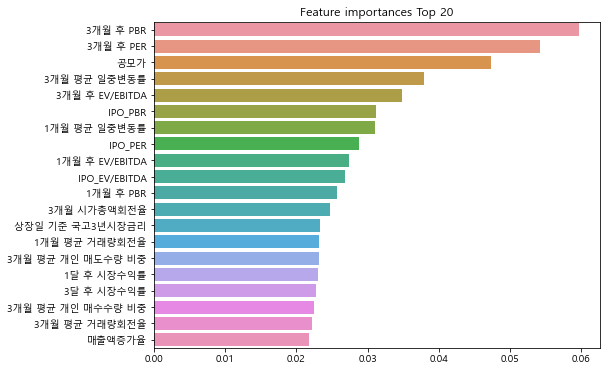

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## LGBM

In [95]:
# LGBM 분류기 객체 생성
lgbm_wrapper = LGBMClassifier(random_state = 0)

# 조기 중단 기능에 필요한 파라미터 정의
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)


# predict, predict_proba 추출
pred = lgbm_wrapper.predict(X_test)
accuracy_xgb = accuracy_score(y_test,pred)
print('lgbm 정확도: {0:.4f}'.format(accuracy_xgb))

[1]	valid_0's multi_logloss: 1.38484
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.36346
[3]	valid_0's multi_logloss: 1.33615
[4]	valid_0's multi_logloss: 1.32064
[5]	valid_0's multi_logloss: 1.30621
[6]	valid_0's multi_logloss: 1.30801
[7]	valid_0's multi_logloss: 1.29931
[8]	valid_0's multi_logloss: 1.2994
[9]	valid_0's multi_logloss: 1.28724
[10]	valid_0's multi_logloss: 1.28252
[11]	valid_0's multi_logloss: 1.2777
[12]	valid_0's multi_logloss: 1.28677
[13]	valid_0's multi_logloss: 1.28063
[14]	valid_0's multi_logloss: 1.27507
[15]	valid_0's multi_logloss: 1.27841
[16]	valid_0's multi_logloss: 1.28209
[17]	valid_0's multi_logloss: 1.27724
[18]	valid_0's multi_logloss: 1.27893
[19]	valid_0's multi_logloss: 1.27731
[20]	valid_0's multi_logloss: 1.28055
[21]	valid_0's multi_logloss: 1.28153
[22]	valid_0's multi_logloss: 1.29261
[23]	valid_0's multi_logloss: 1.29454
[24]	valid_0's multi_logloss: 1.29821
[25]	valid_0's multi_logloss: 1.311
[

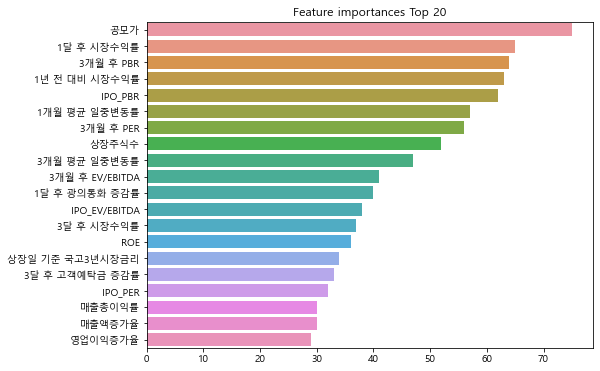

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()